![spam](img/JB1.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1.   Dataset preprocessing

<summary>
    <font size="4" color="orange"><b>1.1 Importing libraries and functions</b></font>
</summary>

In [2]:
# Basic libraries
import numpy as np
import pandas as pd

# Normalization libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import pickle as pk

In [3]:
# Importing PCA functions for futher processing
%run "./funciones/pcafunction.ipynb"

<summary>
    <font size="4" color="orange"><b>1.2 Loading CENACE database: 49 input variables </b></font>
</summary>

<img src="img/calendarsymbol.png" width="40" img align="left" />  

<font size="3" color="palevioletred"><b>Exogenous Calendar Features </b></font>

* **FECHA** (yy-mm-dd): Date

"Holiday" (0|1) indicator:

* **Lunes_Festivo**: Holiday Monday

* **Martes_PostFestivo**: Day after holiday Monday

* **Semana_Santa**: Holy Week

* **1_Mayo**: May 1

* **10_Mayo**: May 10

* **16_Sep**: September 16

* **2_Nov.**: November 2

* **Pre-Navidad_y_new_year**: Day before Christmas or New Year

* **Navidad_y_new_year**: Christmas or New Year

* **Post-Navidad_y_new_year**: Day after Christmas or New Year

<img src="img/lightsymbol.png" alt="drawing" width="25" img align="left" />  

<font size="3" color="palevioletred"><b>Endogenous Feature</b></font>

* **DEM_GCRNO_H$i$** (MW): Load energy demand in GCRNO (Gerencia de Control de Noroeste)  zone from hour $i$ to hour $i+1$ of the corresponding date, for $i=0,\dots 23$.

<img src="img/meteosymbol.png" alt="drawing" width="60" img align="left" />

<font size="3" color="palevioletred"><b>Exogenous Meteorological Features</b></font>

* **TMAX-CAB**, **TMIN-CAB**, **TMAX-HMO**, **TMIN-HMO**, **TMAX-OBR**, **TMIN-OBR**,**TMAX-LMO**, **TMIN-LMO**, **TMAX-CUL**, **TMIN-CUL** ($^\circ$C): Maximum and minimum temperature in Caborca, Hermosillo, Ciudad Obregón, Los Mochis and Culiacán, respectively.

* **PREC_HMO_mm**, **PREC_OBR_mm**, **PREC_LMO_mm**, **PREC_CUL_mm**  (mm/h): Precipitation in Hermosillo, Ciudad Obregón, Los Mochis and Culiacán, respectively.



In [4]:
# Importing load energy consumption CENACE database
url = "./inputs/Dataset GCRNO120522 DF.xlsx" #data
gcrno = pd.read_excel(url)
gcrno.columns

Index(['FECHA', 'DEM_GCRNO_H0', 'DEM_GCRNO_H1', 'DEM_GCRNO_H2', 'DEM_GCRNO_H3',
       'DEM_GCRNO_H4', 'DEM_GCRNO_H5', 'DEM_GCRNO_H6', 'DEM_GCRNO_H7',
       'DEM_GCRNO_H8', 'DEM_GCRNO_H9', 'DEM_GCRNO_H10', 'DEM_GCRNO_H11',
       'DEM_GCRNO_H12', 'DEM_GCRNO_H13', 'DEM_GCRNO_H14', 'DEM_GCRNO_H15',
       'DEM_GCRNO_H16', 'DEM_GCRNO_H17', 'DEM_GCRNO_H18', 'DEM_GCRNO_H19',
       'DEM_GCRNO_H20', 'DEM_GCRNO_H21', 'DEM_GCRNO_H22', 'DEM_GCRNO_H23',
       'TMAX-CAB', 'TMAX-HMO', 'TMAX-OBR', 'TMAX-LMO', 'TMAX-CUL', 'TMIN-CAB',
       'TMIN-HMO', 'TMIN-OBR', 'TMIN-LMO', 'TMIN-CUL', 'PREC_HMO_MM',
       'PREC_OBR_MM', 'PREC_LMO_MM', 'PREC_CUL_MM', 'LUNES_FESTIVO',
       'MARTES_POSTFESTIVO', 'SEMANA_SANTA', '1_MAYO', '10_MAYO', '16_SEP',
       '2_NOV.', 'PRE-NAVIDAD_Y_NEW_YEAR', 'NAVIDAD_Y_NEW_YEAR',
       'POST-NAVIDAD_Y_NEW_YEAR'],
      dtype='object')

<summary>
    <font size="4" color="orange"><b>1.3. Dataframe rearrangement</b></font>
</summary>

The above dataframe will be transorm in a new one with:

* *INSTANCES* (index):

    **FECHA-HORA** (Date-Hour) specified in the format yyyy-mm-dd hh:00:00
    
    
* *FEATURES*: 

    **DEMANDA** Load energy demand
    
    **DIA** (Day)
       0 Monday 
       1 Tuesday 
       2 Wednesday 
       3 Thursday 
       4 Friday 
       5 Saturday 
       6 Sunday
    
    **HORA** (Hour 0–23)
      
    **MES** (Month)
       1 January
       2 February
       3 March
       4 April
       5 May
       6 Jun
       7 July
       8 August
       9 September
       10 Octuber
       11 November
       12 December
    
    And the following characteristics with constant value with respect to the day **TMAX-CAB**, **TMIN-CAB**, **TMAX-HMO**, **TMIN-HMO**, **TMAX-OBR**, **TMIN-OBR**,**TMAX-LMO**, **TMIN-LMO**, **TMAX-CUL**, **TMIN-CUL**, **PREC_HMO_MM**, **PREC_OBR_MM**, **PREC_LMO_MM**, **PREC_CUL_MM**, **LUNES_FESTIVO**, **MARTES_POSTFESTIVO**, **SEMANA_SANTA**, **1_MAYO**, **10_MAYO**, **16_SEP**, **2_NOV.**, **PRE-NAVIDAD_Y_NEW_YEAR**, **NAVIDAD_Y_NEW_YEAR**, **POST-NAVIDAD_Y_NEW_YEAR**.

In [5]:
# Transposing hours columns from the original dataframe into rows
consumo_data = gcrno.melt(
    id_vars= ['FECHA'],
    value_vars= [f'DEM_GCRNO_H{i}' for i in range(24)],
    var_name="HORA",
    value_name="DEMANDA"
).replace(
    {f'DEM_GCRNO_H{i}': i for i in range(24)}
)
# Creating Day, Hour and Month columns
consumo_data.index = consumo_data.FECHA + pd.to_timedelta(consumo_data.HORA, unit='h')
consumo_data.sort_index(inplace=True)
consumo_data.drop(columns=['HORA'], inplace=True)
consumo_data = consumo_data.asfreq('h', method='pad')
consumo_data['FECHAHORA'] = consumo_data.index
consumo_data["DIA"] = consumo_data.index.weekday
consumo_data["HORA"] = consumo_data.index.hour
consumo_data["MES"] = consumo_data.index.month

In [6]:
# Adding columns of exogenous variables
exogenas = gcrno[['FECHA','TMAX-CAB', 'TMAX-HMO', 'TMAX-OBR', 'TMAX-LMO', 'TMAX-CUL', 'TMIN-CAB',
       'TMIN-HMO', 'TMIN-OBR', 'TMIN-LMO', 'TMIN-CUL', 'PREC_HMO_MM',
       'PREC_OBR_MM', 'PREC_LMO_MM', 'PREC_CUL_MM', 'LUNES_FESTIVO',
       'MARTES_POSTFESTIVO', 'SEMANA_SANTA', '1_MAYO', '10_MAYO', '16_SEP',
       '2_NOV.', 'PRE-NAVIDAD_Y_NEW_YEAR', 'NAVIDAD_Y_NEW_YEAR',
       'POST-NAVIDAD_Y_NEW_YEAR']]
consumo = pd.merge(consumo_data, exogenas, on='FECHA', how='left')

In [7]:
# Setting as index the DATE-HOUR
del consumo['FECHA']
consumo.set_index("FECHAHORA", inplace=True)
consumo=consumo.asfreq('h')

In [8]:
# Verifying existence of missing data 
consumo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134664 entries, 2007-01-01 00:00:00 to 2022-05-12 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   DEMANDA                  134664 non-null  int64  
 1   DIA                      134664 non-null  int64  
 2   HORA                     134664 non-null  int64  
 3   MES                      134664 non-null  int64  
 4   TMAX-CAB                 134664 non-null  float64
 5   TMAX-HMO                 134664 non-null  float64
 6   TMAX-OBR                 134664 non-null  float64
 7   TMAX-LMO                 134664 non-null  float64
 8   TMAX-CUL                 134664 non-null  float64
 9   TMIN-CAB                 134664 non-null  float64
 10  TMIN-HMO                 134664 non-null  float64
 11  TMIN-OBR                 134664 non-null  float64
 12  TMIN-LMO                 134664 non-null  float64
 13  TMIN-CUL         

In [9]:
# Adding Date-Hour as 'duplicate' column for flexibility
consumo['FECHA-HORA'] = consumo.index

## 2.   Splitting data into training, test and validation sets


* Training: 70 %
* Validation 20 %
* Test: 10 %

For periodic retraining use all available data and separate just a validation set for the optimization process.

In [10]:
# Splitting the dataset into training, test and validation sets
df_train = consumo[consumo['FECHA-HORA'] < '2020-12-31 00:00:00']
df_test   = consumo[(consumo['FECHA-HORA'] >= '2021-04-30 00:00:00') 
                   & (consumo['FECHA-HORA'] < '2022-04-30 00:00:00')]
df_val  = consumo[(consumo['FECHA-HORA'] >= '2020-12-31 00:00:00') &
                          (consumo['FECHA-HORA'] <= '2021-04-29 00:00:00') ]

## 3.    Feature engineering

The  <font size="3" color="palevioletred"><b>random features</b></font> of the training dataframe are recoded (via a principal component procedure) on the features:


* **PC1_MAX, PC2_MAX, PC1_TMIN, PC2_TMIN, PCI_PREC, PC2_PREC** 


The features **PC2_TMAX**  and **PC2_TMIN** will be ignored later to avoid linear redundance. Then, these and the rest of the features are rescaled into the closed interval $[-1,1]$. The parameters of both procedures are exported and then applied in the test and validation set.

<summary>
    <font size="4" color="orange"><b>3.2. Rescaling all features into a closed interval $[-1,1]$ </b></font>
</summary>

In [11]:
Features = ['DEMANDA', 'MES', 'DIA', 'HORA','TMAX-CAB', 'TMAX-HMO', 'TMAX-OBR', 
            'TMAX-LMO', 'TMAX-CUL', 'TMIN-CAB',
       'TMIN-HMO', 'TMIN-OBR', 'TMIN-LMO', 'TMIN-CUL', 'PREC_HMO_MM',
       'PREC_OBR_MM', 'PREC_LMO_MM', 'PREC_CUL_MM', 'LUNES_FESTIVO',
       'MARTES_POSTFESTIVO', 'SEMANA_SANTA', '1_MAYO', '10_MAYO', '16_SEP',
       '2_NOV.', 'PRE-NAVIDAD_Y_NEW_YEAR', 'NAVIDAD_Y_NEW_YEAR',
       'POST-NAVIDAD_Y_NEW_YEAR']

In [12]:
# Rescaling training set
train = df_train
scalers = {}  # Un diccionario con los scalers

for attr in Features:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(train[attr].values.reshape(-1,1))
    scalers[attr] = scaler
    train[attr] = s_s.ravel()
#train.info()

# Applying training parameters to:
# Validation set 
val = df_val
for attr in Features:
    scaler = scalers[attr]
    s_s = scaler.transform(val[attr].values.reshape(-1,1))
    val[attr] = s_s.ravel()
# Test set
test = df_test
for attr in Features:
    scaler = scalers[attr]
    s_s = scaler.transform(test[attr].values.reshape(-1,1))
    test[attr] = s_s.ravel()

In [13]:
test.to_csv('./outputs/PCA/scaled_test.csv')

In [14]:
# exporting processing parameters for use outside the notebook
pk.dump(scalers, open("./outputs/DataProcessing/scalers.pkl","wb"))

<summary>
    <font size="4" color="orange"><b>3.3 Training set view</b></font>
</summary>

In [15]:
train

,DEMANDA,DIA,HORA,MES,TMAX-CAB,TMAX-HMO,TMAX-OBR,TMAX-LMO,TMAX-CUL,TMIN-CAB,...,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR,FECHA-HORA
FECHAHORA,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,-0.799354,-1.000000,-1.000000,-1.0,-0.414634,-0.318735,-0.257143,0.090909,-0.111111,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2007-01-01 00:00:00
2007-01-01 01:00:00,-0.844096,-1.000000,-0.913043,-1.0,-0.414634,-0.318735,-0.257143,0.090909,-0.111111,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2007-01-01 01:00:00
2007-01-01 02:00:00,-0.863469,-1.000000,-0.826087,-1.0,-0.414634,-0.318735,-0.257143,0.090909,-0.111111,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2007-01-01 02:00:00
2007-01-01 03:00:00,-0.878690,-1.000000,-0.739130,-1.0,-0.414634,-0.318735,-0.257143,0.090909,-0.111111,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2007-01-01 03:00:00
2007-01-01 04:00:00,-0.903598,-1.000000,-0.652174,-1.0,-0.414634,-0.318735,-0.257143,0.090909,-0.111111,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2007-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 19:00:00,-0.434041,-0.333333,0.652174,1.0,-0.536585,-0.318735,-0.542857,-0.303030,-0.740741,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2020-12-30 19:00:00
2020-12-30 20:00:00,-0.381919,-0.333333,0.739130,1.0,-0.536585,-0.318735,-0.542857,-0.303030,-0.740741,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2020-12-30 20:00:00
2020-12-30 21:00:00,-0.387454,-0.333333,0.826087,1.0,-0.536585,-0.318735,-0.542857,-0.303030,-0.740741,-0.55,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2020-12-30 21:00:00


In [16]:
train[['DEMANDA',  'MES', 'DIA', 'HORA','LUNES_FESTIVO','NAVIDAD_Y_NEW_YEAR' ]]

,DEMANDA,MES,DIA,HORA,LUNES_FESTIVO,NAVIDAD_Y_NEW_YEAR
FECHAHORA,,,,,,
2007-01-01 00:00:00,-0.799354,-1.0,-1.000000,-1.000000,-1.0,1.0
2007-01-01 01:00:00,-0.844096,-1.0,-1.000000,-0.913043,-1.0,1.0
2007-01-01 02:00:00,-0.863469,-1.0,-1.000000,-0.826087,-1.0,1.0
2007-01-01 03:00:00,-0.878690,-1.0,-1.000000,-0.739130,-1.0,1.0
2007-01-01 04:00:00,-0.903598,-1.0,-1.000000,-0.652174,-1.0,1.0
...,...,...,...,...,...,...
2020-12-30 19:00:00,-0.434041,1.0,-0.333333,0.652174,-1.0,-1.0
2020-12-30 20:00:00,-0.381919,1.0,-0.333333,0.739130,-1.0,-1.0
2020-12-30 21:00:00,-0.387454,1.0,-0.333333,0.826087,-1.0,-1.0


## 4. Setting the tensors for the encoder

<summary>
    <font size="3" color="palevioletred"><b>Hyperparameters</b></font>
</summary>

* **past** $= (24 \times 7) + 12 = 180$:  Number of instances considered before the day to forecast 

* **skip** $= 12$: Number of instances to skip between the past and the future, this is because CENACE personnel require a 12-hour window to process the information and estimate the forecast

* **future** $= 24$: Number of instances to forecast 


e.g 

<img src="img/time_line.png" alt="drawing" width="200"/>


From hyperparameters we get:

* $m$ = Number of pieces of instances of size $past+skip+future$ that fit on the training, validation and test set, respectively.


<summary>
    <font size="3" color="palevioletred"><b>Tensors dimension</b></font>
</summary>

Past tensors:

$$X_{past,n,m}$$


* $n = 18$: number of features

Future tensors:

$$Y_{future,1,m}$$

* $1$ means that we only consider the load energy demand in the corresponding instance

<img src="img/tensors.png" alt="drawing" width="400"/>


<summary>
    <font size="3" color="palevioletred"><b>Past tensors features</b></font>
</summary>


ENDOGENOUS: Load energy demand in GCRNO at instance yyy-mm-dd hh:mm:ss

* **DEMANDA** 

EXOGENOUS: 

Meteorological data

* **PC1_TMAX**, **PC1_TMIN**, **PC1_PREC**, **PC2_PREC**

Seasonality codification: day in the week, hour in the day, month in the year

* **DIA**, **HORA**, **MES**

Holidays binary features 

* **LUNES_FESTIVO**, **MARTES_POSTFESTIVO**, **SEMANA_SANTA**, **1_MAYO**, **10_MAYO**, **16_SEP**, **2_NOV.**, **PRE-NAVIDAD_Y_NEW_YEAR**, **NAVIDAD_Y_NEW_YEAR**, **POST-NAVIDAD_Y_NEW_YEAR**.

After the end of the process, the columns corresponding to holidays will be have different meaning: e.g. the value 1 in **LUNES_FESTIVO** at instance 2022-03-10 21:00:00 means that the *next day* 2022-03-11 is "holiday Monday". The same for the other holiday. The codification of the day-time instance will be lost.


<summary>
    <font size="4" color="orange"><b>4.1 Setting  $X,Y$ tensors for training, validation and test sets</b></font>
</summary>

In [17]:
# Setting hyperparameters
n_pasado = (24 * 7) + 12
n_futuro = 24
n_salto = 12 

In [18]:
def divide_series(series, indicadores, n_pasado, n_futuro, n_salto, es_train=True):
    """
    n_pasado: number of past observations for the encoder
    n_futuro: number of future observations
    n_salto: from where future observations start to count
    """
    X, y = list(), list() # Vamos a crear listas y al final hacemos ndarrays
    generador = range(len(series)) if es_train else range(0, len(series), n_futuro)

    for ini in generador:
        fin_anterior = ini + n_pasado
        fin_actual = fin_anterior + n_salto + n_futuro
        if fin_actual > len(series):
            break
        pasado = series[ini: fin_anterior, :]
        if len(indicadores) > 0: # replace next day value in "Holidays" features
            for i in range(indicadores.shape[1]):
                pasado = np.c_[pasado, indicadores[fin_anterior + n_salto + 1, i] * np.ones((n_pasado, 1))]
        futuro = series[fin_anterior + n_salto: fin_actual,[0]]
        X.append(pasado)
        y.append(futuro)
            
    return np.array(X), np.array(y)

In [19]:
# Setting past tensors features
features = ['DEMANDA', 
            'MES', 
            'DIA', 
            'HORA',
            'TMAX-CAB', 
            'TMAX-HMO', 
            'TMAX-OBR', 
            'TMAX-LMO', 
            'TMAX-CUL', 
            'TMIN-CAB',
            'TMIN-HMO', 
            'TMIN-OBR', 
            'TMIN-LMO', 
            'TMIN-CUL', 
            'PREC_HMO_MM',
            'PREC_OBR_MM', 
            'PREC_LMO_MM', 
            'PREC_CUL_MM'
           ]
nominal_features = ['LUNES_FESTIVO',
                    'MARTES_POSTFESTIVO', 
                    'SEMANA_SANTA', 
                    '1_MAYO', 
                    '10_MAYO', 
                    '16_SEP',
                    '2_NOV.', 
                    'PRE-NAVIDAD_Y_NEW_YEAR', 
                    'NAVIDAD_Y_NEW_YEAR',
                    'POST-NAVIDAD_Y_NEW_YEAR'
                    ]

In [20]:
n_attr = len(features) + len(nominal_features)
# Setting the tensors
X_train, y_train = divide_series(train[features].values,train[nominal_features].values, n_pasado, n_futuro, n_salto)
X_val, y_val = divide_series(val[features].values, val[nominal_features].values, n_pasado, n_futuro, n_salto)
X_test, y_test = divide_series(test[features].values, test[nominal_features].values, n_pasado, n_futuro, n_salto, es_train=False)

In [21]:
X_train.shape

(122497, 180, 28)

In [22]:
X_val.shape

(2642, 180, 28)

In [23]:
X_test.shape

(357, 180, 28)

<summary>
    <font size="4" color="orange"><b>4.2  Exporting tensors</b></font>
</summary>

In [24]:
np.save('./outputs/split/X_train.npy', X_train)
np.save('./outputs/split/X_val.npy', X_val)
np.save('./outputs/split/X_test.npy', X_test)
np.save('./outputs/split/y_train.npy', y_train)
np.save('./outputs/split/y_val.npy', y_val)
np.save('./outputs/split/y_test.npy', y_test)

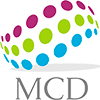

In [25]:
from IPython import display
display.Image("https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png", embed = True)

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>